## Create multiple subsamples of the contigs for statistical analysis
Using the `spacer_bencher subsample` command, we can create meta-data informed subsamples of the contigs. The goal is to keep the subsamples balanced for the different taxonomic groups and genetic features (namely lenth and GC content), while reducing the number of contigs to a manageable number for which all or most of the tools should finish in a reasonable time.
The subsample command requires a contigs file and the metadata in the form of table with at least the columns for the contig names, "Lenght", taxonomy string and GC content. The current table does not have the GC content, so we'll add that column first from the output of the `seqkit fx2tab` command.

In [2]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/')
import polars as pl
import logging
logger = logging.Logger(__name__, logging.INFO)
handler = logging.StreamHandler()
# Set a format that makes log messages clickable in JupyterLab (file:line) # TODO: add this to the functions file main logging logic.
formatter = logging.Formatter('%(filename)s:%(lineno)s - %(asctime)s - %(levelname)s - %(message)s - %(name)s ')
handler.setFormatter(formatter)
logger.addHandler(handler)

pl.Config(tbl_rows=50)

from bench import *
from bench.utils.functions import *
# Import the functionalized subsampling functions
from bench.commands.subsample import subsample_dataset

# Set up parameters for subsampling
contigs_file = 'contigs/IMGVR4_SEQUENCES.fna'
spacers_file = 'spacers/All_CRISPR_spacers_nr_clean.fna'
metadata_file = 'contigs/contig_stats.parquet'
output_dir = 'subsampled_data'
contig_stats  = pl.read_parquet("contigs/contig_stats.parquet")
contig_stats.head(1)
# contig_stats["seqid"].count() #5457198

seqid,length,gc,topology,uvig,hq,…,phylum,class,order,family,genus,species
str,i64,f64,str,str,bool,…,str,str,str,str,str,str
"""IMGVR_UViG_2504643025_000001|2504643025|2504645545|381-5974""",5594,38.36,"""Provirus""","""IMGVR_UViG_2504643025_000001""",true,…,"""Hofneiviricota""","""Faserviricetes""","""Tubulavirales""",null,null,null


In [3]:
# get numeric columns
pl.Config(tbl_rows=50)
bcols = contig_stats.select(pl.selectors.by_dtype([pl.Int64,pl.Float64,pl.UInt64])).columns
contig_stats[bcols].describe()

statistic,length,gc
str,f64,f64
"""count""",5.457198e6,5.457198e6
"""null_count""",0.0,0.0
"""mean""",14866.822494,44.687437
"""std""",19532.347815,10.138021
"""min""",165.0,11.82
"""25%""",5044.0,36.59
"""50%""",7900.0,42.72
"""75%""",16580.0,51.62
"""max""",2.47387e6,78.77


In [4]:
# double checking - by class:
class_stats = contig_stats.group_by("class").agg([pl.len().alias("num_contigs")] + [pl.col(col).mean().alias(f"{col}_mean") for col in bcols] + [pl.col(col).median().alias(f"{col}_median") for col in bcols])
class_stats = class_stats.sort("num_contigs", descending=True)
class_stats

class,num_contigs,length_mean,gc_mean,length_median,gc_median
str,u64,f64,f64,f64,f64
"""Caudoviricetes""",4986008,15611.486625,44.729199,8451.0,42.45
"""Megaviricetes""",101204,19314.214685,38.687854,8847.0,39.58
"""Pisoniviricetes""",94590,3520.00092,42.00405,2380.0,41.57
"""Leviviricetes""",82176,2868.422362,49.972766,3107.0,50.1
"""Howeltoviricetes""",25808,2203.159059,42.401438,2157.0,42.37
"""Miaviricetes""",20623,2274.420889,48.099955,2118.0,49.2
"""Tolucaviricetes""",20099,2643.126325,49.603508,2471.0,49.36
"""Malgrandaviricetes""",19063,4853.663799,44.237085,4638.0,44.37
"""Faserviricetes""",14198,8089.74426,47.933412,7360.0,45.98


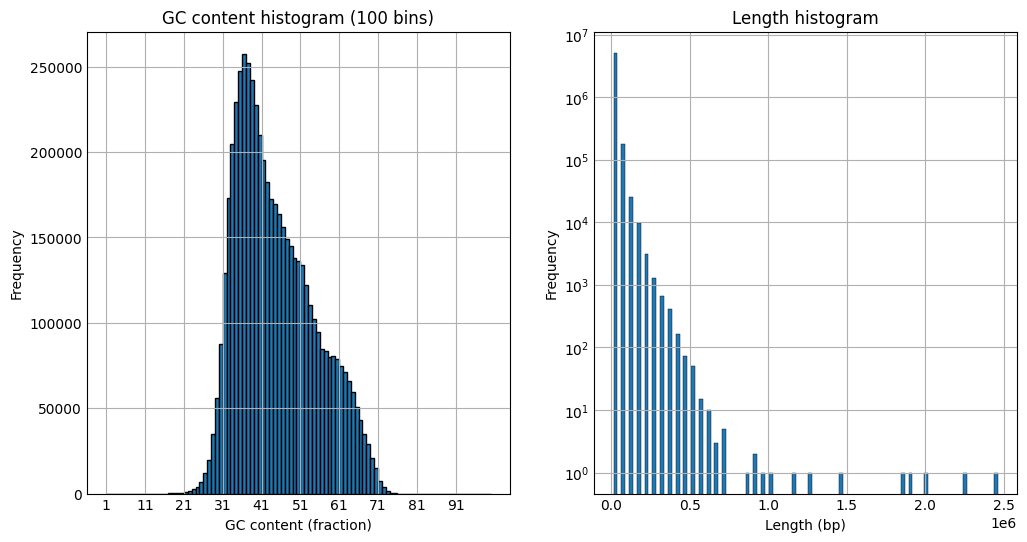

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import numpy as np
gc_bins = np.arange(1, 100.01, 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(contig_stats["gc"], bins=gc_bins, edgecolor='black')
axes[0].set_title('GC content histogram (100 bins)')
axes[0].set_xlabel('GC content (fraction)')
axes[0].set_ylabel('Frequency')
# Filter out the top and bottom 1% outliers for length
length_lower = contig_stats["length"].quantile(0.01)
length_upper = contig_stats["length"].quantile(1)
filtered_lengths = contig_stats.filter(
    (pl.col("length") >= length_lower) & (pl.col("length") <= length_upper)
)

axes[1].hist(filtered_lengths["length"],edgecolor='black',bins=50, linewidth=0.3, rwidth=0.5)
axes[1].set_title('Length histogram')
# set x as log
axes[1].set_yscale('log')
axes[1].set_title('Length histogram')

axes[1].set_xlabel('Length (bp)')
axes[1].set_ylabel('Frequency')
# show grid
axes[0].grid(True)
axes[1].grid(True)
# show ticks for all x values
axes[0].set_xticks([gc_bins[i] for i in range(0, 100, 10)])
# for length show ticks every 10000, but display with kbp units
# axes[1].set_xticks( np.arange(0, 110000, 1000))
# axes[1].set_xticklabels([f"{i//1000}k" for i in np.arange(0, 110000, 1000)])
# set the y axis to log and show the ticks
# axes[1].set_yscale('log')
# axes[1].set_yticks([10**i for i in range(0, 7)])

# show ticks labels
axes[0].tick_params(axis='both', which='both', length=0)
axes[1].tick_params(axis='both', which='both', length=0)
plt.show()
plt.savefig('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/imgvr4_contig_gc_length_distributions.svg')

Next - creating subsamples, of varying sizes 

In [ ]:
fractions = [0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1] #, 0.2]    
for i in fractions:     
    results = subsample_dataset(
    contigs_file='contigs/IMGVR4_SEQUENCES.fna',
    metadata_file='contigs/contig_stats.parquet', 
    output_dir=f'subsamples/fraction_{i}',
    reduce_factor= i, 
    hq_fraction=0.8,    # 80% of high-quality
    taxonomic_rank='class', # trying to keep the taxonomic diversity at this level
    # gc_bins=10,
    # length_bins=10,
    logger=logger,
    extract_method="pyfastx"       
)

Next, calling the spacer_bencher commands on the smallest subsample to get a sense of the runtime.


generating the scripts

running the scripts locally

In [ ]:
%%time
!spacer_bencher run_tools \
  -i /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/subsamples/fraction_0.001 \
  --spacers /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna \
  --contigs /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/subsamples/fraction_0.001/subsampled_data/subsampled_contigs.fa \
  --threads 8 \
  --max_runs 1 \
  --warmups 0 \
  -rt "sassy" # sassy only

In [6]:
%%bash
# testing only minimap2_mod2 and minimap2 (original) with a tiny simulated full run
rm tmp/test_minimaps/ -r
spacer_bencher full-run -nc 1000 -ns 1000 -ir 1 5 -lm 0 3 -cl 2000 200000  -o tmp/test_minimaps/ --threads 4 \
    --only-tools indelfree_bruteforce,minimap2 \
         --verbose

[11/10/25 13:25:48] INFO     STARTING FULL PIPELINE RUN               ]8;id=116242;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/cli.py\cli.py]8;;\:]8;id=990167;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/cli.py#367\367]8;;\
[11/10/25 13:25:48] INFO     [1/4] SIMULATING DATA                    ]8;id=346614;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/cli.py\cli.py]8;;\:]8;id=880915;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/cli.py#371\371]8;;\
[11/10/25 13:25:48] INFO     Starting simulation: 1000 contigs,   ]8;id=987473;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/simulate.py\simulate.py]8;;\:]8;id=696073;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/simulate.py#47\47]8;;\
                             1000 

Parsing SAM file: 30534it [00:00, 199155.41it/s]



Reading results for minimap2...
File size: 0.20 MB
 output file  tmp/test_minimaps//raw_outputs//minimap2_output.sam exists
first line of sam file @HD	VN:1.6	SO:unsorted	GO:query
second line of sam file @SQ	SN:65034638_contig_318	LN:164413
Found 1000 SQ lines, 1 PG lines
SAM file looks good, no changes needed
Reading results for minimap2...
File size: 0.20 MB
 output file  tmp/test_minimaps//raw_outputs//minimap2_output.sam exists
first line of sam file @HD	VN:1.6	SO:unsorted	GO:query
second line of sam file @SQ	SN:65034638_contig_318	LN:164413
Found 1000 SQ lines, 1 PG lines
SAM file looks good, no changes needed


Parsing SAM file: 1231it [00:00, 209196.88it/s]


[11/10/25 13:27:50] INFO     Read 31497 total alignment   ]8;id=872885;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py\compare_results.py]8;;\:]8;id=541096;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py#826\826]8;;\
                             results                                            
                             results                                            
[11/10/25 13:27:50] DEBUG    Wrote tool results to        ]8;id=65420;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py\compare_results.py]8;;\:]8;id=411094;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py#831\831]8;;\
                             tmp/test_minimaps//tools_res                       
                             ults.tsv           

3215rows [00:00, 23326.16rows/s]


[11/10/25 13:27:51] DEBUG    Exact matches from            ]8;id=62755;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py\compare_results.py]8;;\:]8;id=526278;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py#89\89]8;;\
                             validation: 3054                                   
[11/10/25 13:27:51] DEBUG    Partial overlaps: 140 (will   ]8;id=65567;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py\compare_results.py]8;;\:]8;id=287109;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/compare_results.py#90\90]8;;\
                             be verified)                                       
[11/10/25 13:27:51] DEBUG    False positives to           ]8;id=713665;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blit

# Running Tools on Subsamples via SLURM

Let's create and submit SLURM jobs to run each tool on each subsample. We'll:
1. Generate tool scripts for each subsample
2. Modify scripts to use correct paths
3. Create SLURM job scripts
4. Submit the jobs

In [8]:
# First, create the directory structure for each subsample
from pathlib import Path
fractions = [0.001, 0.005, 0.01, 0.05,  0.1] # 0.07, 0.03

for frac in fractions:
    base_dir = f'/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_{frac}'
    
    # Create all needed subdirectories
    for subdir in ['slurm_logs', 'results', 'bash_scripts', 'raw_outputs']:
        Path.mkdir(Path(base_dir + '/' + subdir),exist_ok=True)

Next, we'll modify the bash scripts to use the real data

In [ ]:
import os
from bench.utils.pyseff import create_slurm_job_scripts
from bench.utils.tool_commands import load_tool_configs
from bench.utils.functions import create_bash_script

fractions = [0.001, 0.005, 0.01, 0.05,  0.1] # 0.07, 0.03
all_created = {}
spacers = "/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna"

for frac in fractions:
    base_dir = f"/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_{frac}"
    contigs = f"{base_dir}/subsampled_data/subsampled_contigs.fa"
    print('Preparing bash scripts for', base_dir)
    os.makedirs(f"{base_dir}/bash_scripts", exist_ok=True)
    os.makedirs(f"{base_dir}/raw_outputs", exist_ok=True)

    # Load tool configs and generate bash scripts (hyperfine=False to write direct tool commands)
    tools = load_tool_configs(results_dir=base_dir, threads=8, contigs_file=contigs, spacers_file=spacers)
    created_tools = []
    for tool_name, tool in tools.items():
        try:
            create_bash_script(tool, base_dir, max_runs=1, warmups=0, hyperfine=False)
            created_tools.append(tool_name)
        except Exception as e:
            print(f"Failed to create script for {tool_name}: {e}")

    print('Creating SLURM job scripts for', base_dir)
    created_jobs = create_slurm_job_scripts(base_dir,threads=8)
    print(' Created job scripts:', len(created_jobs))

    all_created[frac] = {'tools': created_tools, 'jobs': created_jobs}

all_created

Preparing bash scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001
Creating SLURM job scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001
 Created job scripts: 12
Preparing bash scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.005
Creating SLURM job scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.005
 Created job scripts: 12
Preparing bash scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.01
Creating SLURM job scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.01
 Created job scripts: 12
Preparing bash scripts for /clusterfs/jgi/scratch/science/metagen/neri/code/blits

{0.001: {'tools': ['blastn',
   'bowtie1',
   'bowtie2',
   'indelfree_bruteforce',
   'indelfree_indexed',
   'lexicmap',
   'minimap2',
   'mmseqs2',
   'mummer4',
   'sassy',
   'strobealign',
   'x_mapper'],
  'jobs': ['/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/blastn.sh',
   '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/bowtie1.sh',
   '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/bowtie2.sh',
   '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/indelfree_bruteforce.sh',
   '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/indelfree_indexed.sh',
   '/clusterfs/jgi/scratch/science/metagen/neri/code/

Next we'll make a slurm scripts to submit the tools as seperate jobs.

and run the tools as seperate jobs.

In [9]:
%%bash
# Submit all jobs for each tool-subsample combination
# fractions=(0.001 0.005 0.01 0.03 0.05 0.07 0.1)
fractions=(0.001 0.005 0.01 0.05  0.1) # 0.07, 0.03

for frac in "${fractions[@]}"; do
    base_dir="/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_${frac}"
    
    echo "Submitting jobs for fraction ${frac}"
    for script in $(ls ${base_dir}/job_scripts/*.sh 2>/dev/null || true); do
        if [ -f "$script" ]; then
            echo "Submitting $script"
            sbatch "$script"
        fi
    done
done

Submitting jobs for fraction 0.001
Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/blastn.sh
Submitted batch job 19675891
Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/bowtie1.sh
Submitted batch job 19675892
Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/bowtie2.sh
Submitted batch job 19675893
Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/indelfree_bruteforce.sh
Submitted batch job 19675894
Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.001/job_scripts/indelfree_indexed.sh
Submitted batch job 19675895
Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/sp

## Resubmit timed-out jobs to jgi_long queue

Check SLURM logs for jobs that hit the time limit and resubmit them with longer wall time.

In [2]:
import os
import glob
from bench.utils.pyseff import create_slurm_job_scripts

fractions = [0.001, 0.005, 0.01, 0.05, 0.1]

# Check for timed-out jobs by scanning SLURM error logs
timed_out_jobs = {}

for frac in fractions:
    base_dir = f"/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_{frac}"
    log_dir = f"{base_dir}/slurm_logs"
    
    if not os.path.exists(log_dir):
        continue
    
    # Find all .err files
    err_files = glob.glob(f"{log_dir}/*.err")
    
    for err_file in err_files:
        try:
            with open(err_file, 'r') as f:
                content = f.read()
                # Check for timeout indicators
                if 'TIME LIMIT' in content or 'DUE TO TIME LIMIT' in content:
                    # Extract tool name from filename (e.g., "indelfree_bruteforce-19675918.err")
                    tool_name = os.path.basename(err_file).split('-')[0]
                    
                    if frac not in timed_out_jobs:
                        timed_out_jobs[frac] = []
                    if tool_name not in timed_out_jobs[frac]:
                        timed_out_jobs[frac].append(tool_name)
        except Exception as e:
            print(f"Error reading {err_file}: {e}")

# Display timed-out jobs
print("Timed-out jobs by fraction:")
for frac, tools in timed_out_jobs.items():
    print(f"  fraction_{frac}: {', '.join(tools)}")


Timed-out jobs by fraction:
  fraction_0.01: indelfree_bruteforce
  fraction_0.05: indelfree_bruteforce, sassy
  fraction_0.1: indelfree_bruteforce, indelfree_indexed, sassy


In [5]:
# Now resubmit these jobs with longer time and jgi_long queue
if timed_out_jobs:
    print("\nCreating new job scripts for timed-out jobs with extended time...")
    
    # Updated SLURM options for long queue
    long_queue_opts = {
        'mail-user': 'uneri@lbl.gov',
        'mail-type': 'FAIL,END,BEGIN',
        'A': 'grp-org-sc-metagen',
        'q': 'jgi_long',      # Changed from jgi_normal
        'c': 16,
        'mem': '168G',
        't': '168:00:00',     # 7 days instead of 72 hours
    }
    
    resubmit_info = {}
    
    for frac, tools in timed_out_jobs.items():
        base_dir = f"/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_{frac}"
        bash_dir = f"{base_dir}/bash_scripts"
        job_dir = f"{base_dir}/job_scripts_long"
        log_dir = f"{base_dir}/slurm_logs"
        
        os.makedirs(job_dir, exist_ok=True)
        
        created_scripts = []
        
        for tool in tools:
            bash_script = f"{bash_dir}/{tool}.sh"
            
            # Check if the bash script exists
            if not os.path.exists(bash_script):
                print(f"  Warning: bash script not found: {bash_script}")
                continue
            
            # Create SLURM job script manually for this tool
            job_file = f"{job_dir}/{tool}.sh"
            
            with open(job_file, 'w') as jf:
                jf.write('#!/bin/bash\n')
                for k, v in long_queue_opts.items():
                    # Single-letter options use space, multi-letter use equals
                    if len(str(k)) == 1:
                        jf.write(f"#SBATCH -{k} {v}\n")
                    else:
                        jf.write(f"#SBATCH --{k}={v}\n")
                
                jf.write(f"#SBATCH -J \"{tool}_long\"\n")
                jf.write(f"#SBATCH -o {log_dir}/{tool}_long-%A.out\n")
                jf.write(f"#SBATCH -e {log_dir}/{tool}_long-%A.err\n\n")
                
                # Import shlex for safe quoting
                import shlex
                jf.write(f"bash {shlex.quote(bash_script)} \"$SLURM_CPUS_PER_TASK\"\n")
            
            os.chmod(job_file, 0o755)
            created_scripts.append(job_file)
        
        resubmit_info[frac] = created_scripts
        print(f"  fraction_{frac}: created {len(created_scripts)} job scripts in {job_dir}")
    
    print("\nResubmit info:")
    print(resubmit_info)
else:
    print("\nNo timed-out jobs found.")

timed_out_jobs


Creating new job scripts for timed-out jobs with extended time...
  fraction_0.01: created 1 job scripts in /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.01/job_scripts_long
  fraction_0.05: created 2 job scripts in /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.05/job_scripts_long
  fraction_0.1: created 3 job scripts in /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.1/job_scripts_long

Resubmit info:
{0.01: ['/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.01/job_scripts_long/indelfree_bruteforce.sh'], 0.05: ['/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.05/job_scripts_long/indelfree_bruteforce.sh', '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_d

{0.01: ['indelfree_bruteforce'],
 0.05: ['indelfree_bruteforce', 'sassy'],
 0.1: ['indelfree_bruteforce', 'indelfree_indexed', 'sassy']}

In [8]:
%%bash
# Submit the long-running jobs
fractions=(0.001 0.005 0.01 0.05 0.1)

for frac in "${fractions[@]}"; do
    base_dir="/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_${frac}"
    job_dir="${base_dir}/job_scripts_long"
    
    if [ -d "$job_dir" ]; then
        echo "Submitting long-queue jobs for fraction ${frac}"
        for script in $(ls ${job_dir}/*.sh 2>/dev/null || true); do
            if [ -f "$script" ]; then
                echo "  Submitting $script"
                sbatch "$script"
            fi
        done
    fi
done

Submitting long-queue jobs for fraction 0.01
  Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.01/job_scripts_long/indelfree_bruteforce.sh
  Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.01/job_scripts_long/indelfree_bruteforce.sh
Submitted batch job 19865712
Submitting long-queue jobs for fraction 0.05
Submitted batch job 19865712
Submitting long-queue jobs for fraction 0.05
  Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.05/job_scripts_long/indelfree_bruteforce.sh
  Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction_0.05/job_scripts_long/indelfree_bruteforce.sh
Submitted batch job 19865713
  Submitting /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/subsamples/fraction